# RMSProp
为了解决Adagrad中$s$因为梯度累加效应使得分母特别大,从而导致整体学习率特别小,损失难以快速收敛.

**Adagrad**:
$$
s_i = s_{i-1} + \ g^2
$$
$$
\theta_{i+1} = \theta_i- \frac{\eta}{\sqrt{s_i + \epsilon}}\nabla L(\theta)
$$
**RMSProp**:
$$
s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2
$$
$$
\theta_{i+1} = \theta_i- \frac{\eta}{\sqrt{s_i + \epsilon}}\nabla L(\theta)
$$
限制了$s$变得非常大,因为前面分别有两个系统来控制.

可见,RMSProp比Adagrad多了一个$\alpha$系数,其他的公式一致.

## 一.手动实现RMSProp

### 导入数据

In [3]:

import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('../data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('../data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [4]:
def rmsprop(parameters, sqrs, lr, alpha):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = alpha * sqr + (1 - alpha) * param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

### 1. $\alpha$=0.9

In [6]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.9) # 学习率设为 0.001，alpha 设为 0.9
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.378133
epoch: 1, Train Loss: 0.171770
epoch: 2, Train Loss: 0.125409
epoch: 3, Train Loss: 0.101692
epoch: 4, Train Loss: 0.086425
使用时间: 33.59566 s


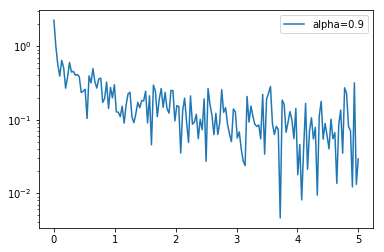

In [7]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.9')
plt.legend(loc='best')

### 2. $\alpha$=0.999

In [ ]:

train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.999) # 学习率设为 0.001，alpha 设为 0.999
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.488090
epoch: 1, Train Loss: 0.177212
epoch: 2, Train Loss: 0.136316
epoch: 3, Train Loss: 0.112787


In [ ]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.999')
plt.legend(loc='best')

## 二.使用torch自带:torch.optim.RMSProp(model.parameters(),lr=,$\alpha$=)

In [ ]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, alpha=0.9)
    
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))